In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn
%matplotlib inline

In [6]:
FileName = '/home/zsc/ADS_B_select_files_/20201106/20201106063157__HeadFile_1090000000_6000000_186666677_780df9_thd(600).dat'
sig = np.memmap(FileName,dtype='int16',mode='r')
SAMPLE_RATE = 186666677
BOND_WIDTH = 6000000


In [7]:
sig.shape
N = len(sig)
N

49152

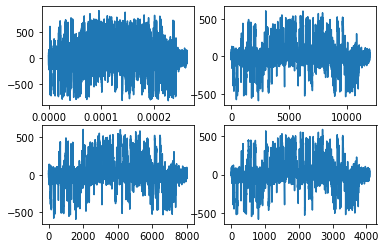

In [8]:
x = np.linspace(0.0, N/SAMPLE_RATE, N)

plt.figure(1)

plt.subplot(2,2,1)
plt.plot(x,sig)
plt.subplot(2,2,2)
plt.plot(sgn.resample(sig,12000))
plt.subplot(2,2,3)
plt.plot(sgn.resample(sig,8000))
plt.subplot(2,2,4)
plt.plot(sgn.resample(sig,64*64))
plt.show()

In [9]:
import scipy
f_fft = scipy.fft.fft(sig)
# plt.plot(f_fft)

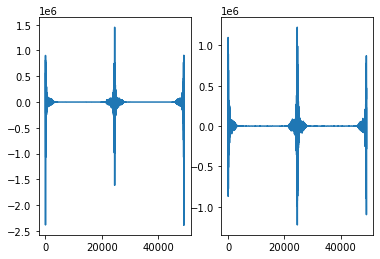

In [10]:
plt.figure(1)
plt.subplot(1,2,1)
plt.plot(np.real(f_fft))    #实轴
plt.figure(1)
plt.subplot(1,2,2)
plt.plot(np.imag(f_fft))    #虚轴

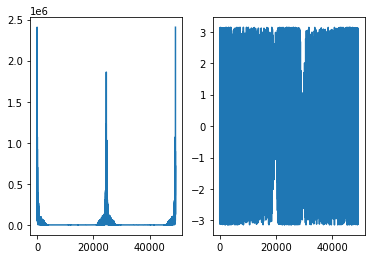

In [11]:
abs_f = np.abs(f_fft)
angle_f = np.angle(f_fft)
plt.figure(2)
plt.subplot(1,2,1)
plt.plot(abs_f)    #振幅谱

plt.figure(2)
plt.subplot(1,2,2)
plt.plot(angle_f)    #相位谱

In [12]:
def high_pass_filter(x, low_cutoff=1000, SAMPLE_RATE=SAMPLE_RATE):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = scipy.signal.butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = scipy.signal.sosfilt(sos, x)

    return filtered_sig

In [13]:
import pywt 
import seaborn as sns
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

In [14]:

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = sgn.butter(order, normal_cutoff, btype='low', analog=False)
    y = sgn.filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = sgn.butter(order, normal_cutoff, btype='high', analog=False)
    y = sgn.filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, cutoff_low, cuttoff_high, fs, order):
    nyq = 0.5*fs
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cuttoff_high / nyq    
    # Get the filter coefficients 
    b, a = sgn.butter(order, [normal_cutoff_low,normal_cutoff_high], btype='band', analog=False)
    y = sgn.filtfilt(b, a, data)
    return y

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

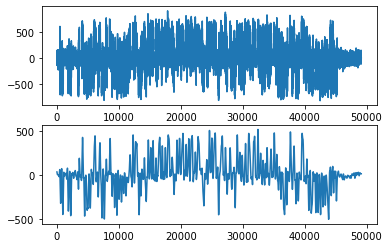

In [15]:
plt.subplot(2,1,1)
plt.plot(sig)
plt.subplot(2,1,2)
sig1 = butter_lowpass_filter(sig,1*10**6,SAMPLE_RATE,5)
plt.plot(sig1)


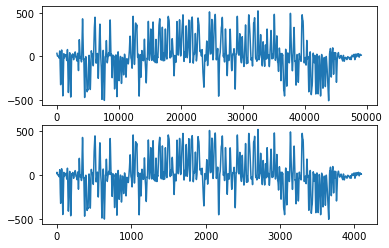

In [16]:
plt.subplot(2,1,1)
plt.plot(sig1)
plt.subplot(2,1,2)
plt.plot(sgn.resample(sig1,64*64))

# 小波族
1. haar family: haar
2. db family: db1,db2,db3,db4,db5,db6,db7,db8,db9,db10,db11,db12,db13,db14,db15,db16,db17,db18,db19,db20,db21,db22,db23,db24,db25,db26,db27,db28,db29,db30,db31,db32,db33,db34,db35,db36,db37,db38
3. sym family: sym2,sym3,sym4,sym5,sym6,sym7,sym8,sym9,sym10,sym11,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20
4. coif family: coif1,coif2,coif3,coif4,coif5,coif6,coif7,coif8,coif9,coif10,coif11,coif12,coif13,coif14,coif15,coif16,coif17
5. bior family: bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,bior3.7,bior3.9,bior4.4,bior5.5,bior6.8
6. rbio family: rbio1.1,rbio1.3,rbio1.5,rbio2.2,rbio2.4,rbio2.6,rbio2.8,rbio3.1,rbio3.3,rbio3.5,rbio3.7,rbio3.9,rbio4.4,rbio5.5,rbio6.8
7. dmey family: dmey
8. gaus family: gaus1,gaus2,gaus3,gaus4,gaus5,gaus6,gaus7,gaus8
9. mexh family: mexh
10. morl family: morl
11. cgau family: cgau1,cgau2,cgau3,cgau4,cgau5,cgau6,cgau7,cgau8
12. shan family: shan
13. fbsp family: fbsp
14. cmor family: cmor


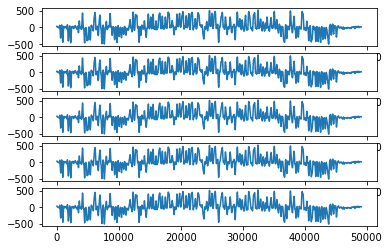

In [17]:
# plt.figure(3)
# plt.subplot(2,2,1)
# sig1 = high_pass_filter(sig)
# plt.plot(sig1)
# plt.subplot(2,2,2)
# sig2 = butter_lowpass_filter(sig1,50000000,SAMPLE_RATE,5)
# plt.plot(sig2)
plt.subplot(5,1,1)
plt.plot(denoise_signal(sig1,wavelet='haar'))    #haar
plt.subplot(5,1,2)
plt.plot(denoise_signal(sig1,wavelet='haar'))    #haar
plt.subplot(5,1,3)
plt.plot(denoise_signal(sig1,wavelet='db3'))    #db3
plt.subplot(5,1,4)
plt.plot(denoise_signal(sig1,wavelet='sym3'))    #sym8
plt.subplot(5,1,5)
plt.plot(denoise_signal(sig1,wavelet='coif3'))    #coif3

/home/zsc/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zsc/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zsc/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


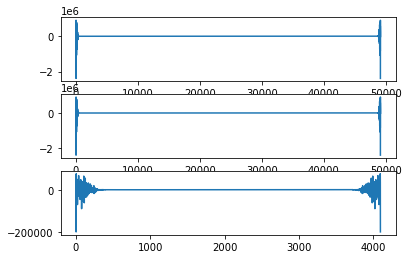

In [18]:
plt.subplot(3,1,1)
plt.plot(scipy.fft.fft(sig1))    
plt.subplot(3,1,2)
sig2 = denoise_signal(sig1,wavelet='db3')
plt.plot(scipy.fft.fft(sig2))  
plt.subplot(3,1,3)
plt.plot(scipy.fft.fft(sgn.resample(sig2,64*64)))

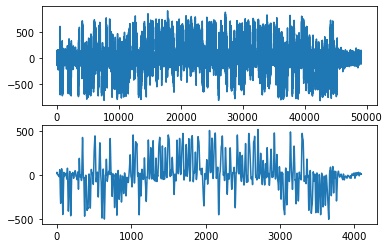

In [19]:
plt.subplot(2,1,1)
plt.plot(sig)
plt.subplot(2,1,2)
plt.plot(sgn.resample(sig2,64*64))